In [2]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
import math
import MDAnalysis as mda
import mpld3
from tqdm import notebook
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets

In [3]:
def fitPlaneLTSQ(XYZ):
    '''
    Fits plane to set of points
    Source:
    https://gist.github.com/RustingSword/e22a11e1d391f2ab1f2c
    '''
    (rows, cols) = XYZ.shape
    G = np.ones((rows, 3))
    G[:, 0] = XYZ[:, 0]  #X
    G[:, 1] = XYZ[:, 1]  #Y
    Z = XYZ[:, 2]
    (a, b, c),resid,rank,s = np.linalg.lstsq(G, Z)
    normal = (a, b, -1)
    nn = np.linalg.norm(normal)
    normal = normal / nn
    return (c, normal)

def classify( x ):
    '''
    Classifies the triangle of Delaunay triangulation
    as triangle formed by lipids (a=1), by lipids and polymers (a=2)
    or by polymers alone (a=3)
    '''
    a = 1
    lipidexist = False
    polexist = False
    for i in x:
        if i < border:
            lipidexist = True
        if i >= border:
            polexist = True
    if lipidexist and polexist:
        a = 2
    elif not lipidexist and polexist:
        a = 3
    return a

def rotation_matrix(axis, theta):
    """
    Returns the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    Source:
    https://stackoverflow.com/questions/6802577/rotation-of-3d-vector
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [4]:
def get_projected_points( normal, points ):
    '''
    Finds projections of points onto a plane given by normal
    with the point (0,0,0). Then rotates those projections into xy plane.
    Source:
    https://math.stackexchange.com/questions/100761/how-do-i-find-the-projection-of-a-point-onto-a-plane
    https://math.stackexchange.com/questions/1167717/transform-a-plane-to-the-xy-plane
    '''
    # Calculate array of displaces for each point to get projections onto plane with @normal and point (0,0,0)
    t = - np.einsum('j,ij', normal, points)
    # Apply those displaces to each point to get projections of points onto plane with @normal and point (0,0,0)
    projected_points = points + np.outer(t,normal)
    # Derive angle between plane with @normal and xy-plane with (0,0,1)
    cos_theta = np.dot(normal,[0,0,1])
    theta = np.arccos(cos_theta)
    # Derive axis of rotation
    axis = np.cross(normal,[0,0,1])
    # Rotate points' projections onto xy-plane
    final_points_3D = np.matmul(rotation_matrix(axis, theta), projected_points.T).T
    # Reduce 3D-array to 2D-array of points' coordinates by deleting z-coordinate
    final_points_2D = np.delete(final_points_3D,obj=2,axis=1)
    # You can return all sets of points to plot them and check if script works properly
    return final_points_2D
    #return final_points_2D, projected_points, final_points_3D
    
def get_projected_points_1(c, normal, points ):
    # Calculate array of displaces for each point to get projections onto plane with @normal and point (0,0,c)
    subtract = points - np.array([0,0,c])
    t = np.einsum('j,ij', normal, subtract)
    # Apply those displaces to each point to get projections of points onto plane with @normal and point (0,0,c)
    projected_points = points + np.outer(t,normal)
    return projected_points

def get_projected_points_2( normal, points ):
    # Derive angle between plane with @normal and xy-plane with (0,0,1)
    cos_theta = np.dot(normal,[0,0,1])
    theta = np.arccos(cos_theta)
    # Derive axis of rotation
    axis = np.cross(normal,[0,0,1])
    # Rotate points' projections onto xy-plane
    final_points_3D = np.matmul(rotation_matrix(axis, theta), points.T).T
    # Reduce 3D-array to 2D-array of points' coordinates by deleting z-coordinate
    final_points_2D = np.delete(final_points_3D,obj=2,axis=1)
    # You can return all sets of points to plot them and check if script works properly
    return final_points_2D
    #return final_points_2D, projected_points, final_points_3D

In [5]:
start_frame = 0
end_frame = 1000000
interval = 1

In [6]:
#membrane = 'SMALP_npt.gro'
membrane = 'SMALP_ions.gro'
#traj = 'SMALP_npt.xtc'
traj = 'test.xtc'
universe = mda.Universe(membrane, traj)

In [7]:
selection1 = 'resname DMPC and name C27'
selection2 = '(resname ST1 ST2 MAL MAR DB1 DB2 MAD MA2 and name CA CB) or (protein and name CA)'
lipid_group = universe.select_atoms(selection1)
polymer_group = universe.select_atoms(selection2)

In [8]:
ts_list = []
apl_list = []
for ts in notebook.tqdm(universe.trajectory):
    if (ts.frame >= start_frame) and (ts.frame <= end_frame):
        if ts.frame%interval == 0:
            positions = lipid_group.atoms.positions[:]
            c, normal = fitPlaneLTSQ(positions)
        # Get atom coordinates
        lipid_atoms = lipid_group.atoms.positions[:]
        polymer_atoms = polymer_group.atoms.positions[:]
        # Get 2D atom projections onto plane fitted to lipid headgroups
        points_lipid = get_projected_points(normal, lipid_atoms)
        # There two options to do that:
        #       1. Count all polymer atoms including those which are hanging over lipid membrane
        #points_pol = get_projected_points(normal, polymer_atoms)
        
        #       2. Doesn't count polymer atoms which are hanging over lipid membrane
        #         (distance between their positions and their projections are greater than 20 angstroms)
        points_pol_1 = get_projected_points_1(c, normal, polymer_atoms)
        pol_delta = polymer_atoms-points_pol_1
        dist = np.sqrt(np.einsum('ij,ij->i', pol_delta, pol_delta))
        points_pol_1 = points_pol_1[dist<20]
        points_pol_2 = get_projected_points_2(normal, points_pol_1)
        points_pol = points_pol_2
        
        #points_lipid, projected_points, rotated_points = get_projected_points(normal, lipid_atoms)
        #points_pol, ghgh, fhf = get_projected_points(normal, polymer_atoms)
        points = np.concatenate((points_lipid, points_pol), axis=0)
        # Plot Delaunay tesselation
        dela = Delaunay(points)
        # border = the first index in final_array which stands for polymer record = number of lipids
        border = points_lipid.shape[0]
        simplices_array = np.column_stack((dela.simplices[:], np.apply_along_axis(classify, axis=1, arr=dela.simplices[:])))
        SUM = 0
        # Calculate Area
        for triangle in simplices_array:
            if triangle[3]==3:
                pass
            elif triangle[3]==2:
                pass
                Ax, Ay = points[triangle[0],0], points[triangle[0],1]
                Bx, By = points[triangle[1],0], points[triangle[1],1]
                Cx, Cy = points[triangle[2],0], points[triangle[2],1]
                SUM+=abs(Ax*(By-Cy)+Bx*(Cy-Ay)+Cx*(Ay-By))/4
            elif triangle[3]==1:
                Ax, Ay = points[triangle[0],0], points[triangle[0],1]
                Bx, By = points[triangle[1],0], points[triangle[1],1]
                Cx, Cy = points[triangle[2],0], points[triangle[2],1]
                SUM+=abs(Ax*(By-Cy)+Bx*(Cy-Ay)+Cx*(Ay-By))/2
        APL = SUM/border
        apl_list.append(APL)
        ts_list.append(ts.frame)
    elif ts.frame > end_frame:
        break

/home/tarasov/Software/anaconda2/envs/mdaenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


In [9]:
lipid_group.atoms.positions[0:5]

array([[ 96.97    ,  93.16    ,  71.740005],
       [ 85.39001 ,  99.03001 ,  63.180004],
       [ 93.56001 ,  89.61    ,  63.640003],
       [ 87.43    , 107.81    ,  64.9     ],
       [ 99.990005,  82.33001 ,  66.08    ]], dtype=float32)

In [10]:
# APL must be multiplied by 2 because lipids from both monolayers were accounted for
# Also if used not single atom of each lipid molecule
# APL is to be multiplied by number of atoms used to get correct APL values
new_apl_list = np.multiply(apl_list,2)

In [11]:
np.savetxt('APL_0.0.csv', np.c_[ts_list, new_apl_list], fmt=('%.d','%.4f'), delimiter='   ', header='APL vs frame. 13 nm DMPC-SMALP with 0.0 charge of maleic acid monomer')

<IPython.core.display.Javascript object>


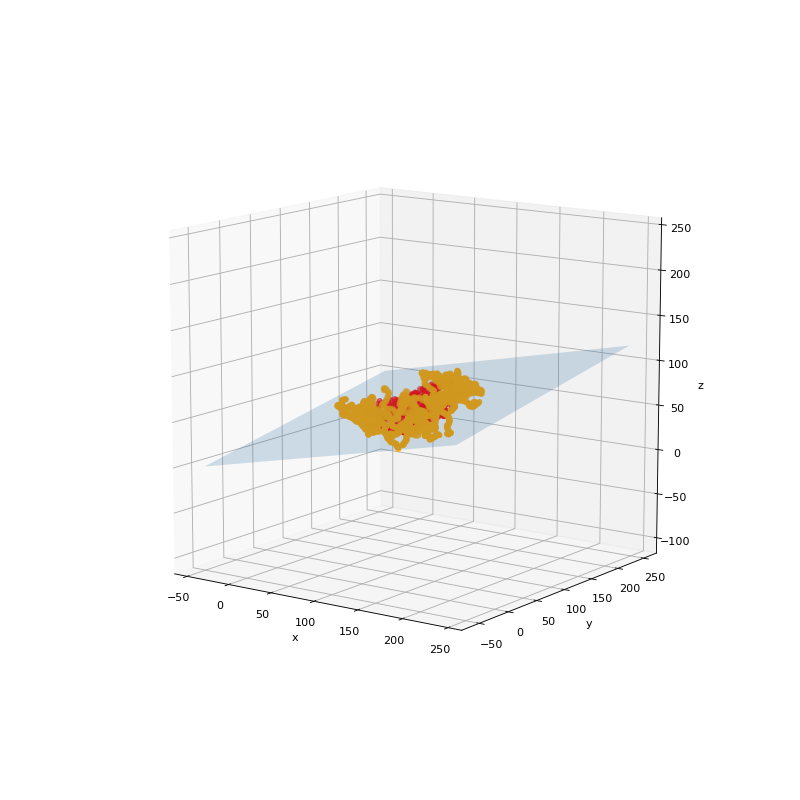

Text(0.5, 0, 'z')

In [15]:
%matplotlib widget
fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

#selection3 = 'resname DMPC and name C28'
#test_group = universe.select_atoms(selection3)
#test_atoms = test_group.atoms.positions[:]
#ax.scatter(test_atoms[:, 0], test_atoms[:, 1], test_atoms[:, 2], color='g')

ax.scatter(lipid_atoms[:, 0], lipid_atoms[:, 1], lipid_atoms[:, 2], color='r')
#ax.scatter(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2], color='b')
#ax.scatter(rotated_points[:, 0], rotated_points[:, 1], rotated_points[:, 2], color='g')
#ax.scatter(points_lipid[:, 0], points_lipid[:, 1], np.zeros(points_lipid.shape[0]), color='black')

ax.scatter(polymer_atoms[:, 0], polymer_atoms[:, 1], polymer_atoms[:, 2], color='orange')

# plot fitted plane
maxx = np.max(lipid_atoms[:,0]+100)
maxy = np.max(lipid_atoms[:,1]+100)
minx = np.min(lipid_atoms[:,0]-100)
miny = np.min(lipid_atoms[:,1]-100)

point = np.array([0.0, 0.0, c])
d = -point.dot(normal)

# compute needed points for plane plotting
xx, yy = np.meshgrid([minx, maxx], [miny, maxy])
z = (-normal[0]*xx - normal[1]*yy - d)*1. / normal[2]

# plot plane
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_zlim3d(-110, 250)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

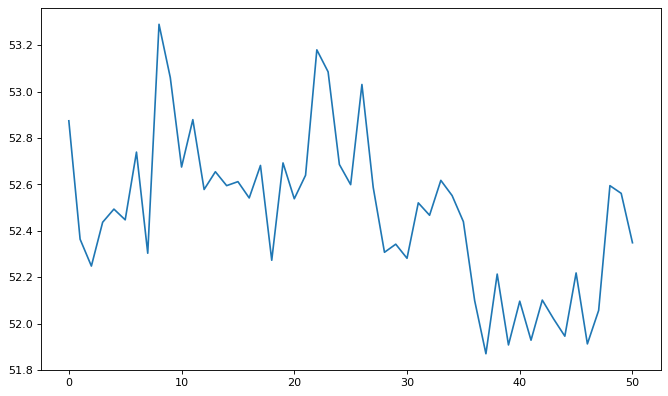

In [14]:
%matplotlib inline
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ts_list, new_apl_list)
#plt.savefig('APL_vs_time.png')

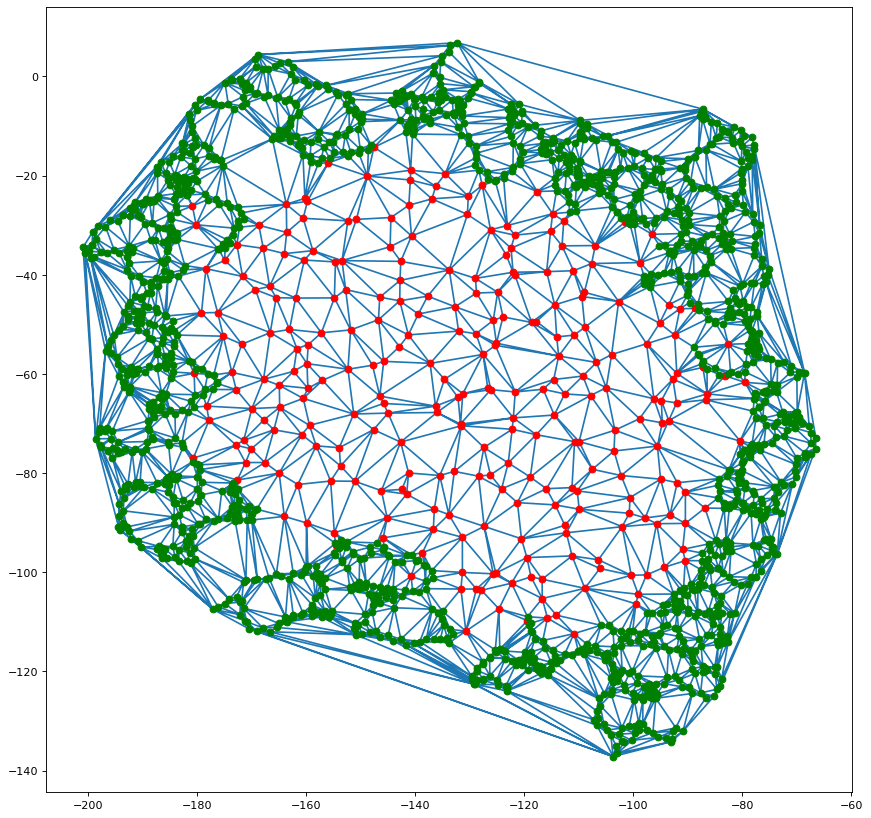

In [16]:
%matplotlib inline
plt.figure(num=None, figsize=(13, 13), dpi=80, facecolor='w', edgecolor='k')
plt.triplot(points[:,0], points[:,1], dela.simplices)
plt.plot(points_lipid[:,0], points_lipid[:,1], 'o', color='r')
plt.plot(points_pol[:,0], points_pol[:,1], 'o', color='g')
plt.savefig('without_overhanging_polymers.png')